## Homework 4

Question: Function ‘predict_prices provides a fit of the stock data by using SVR with three different kernels. However, SVR also supports some other kernels. Add these kernels to the test, run it, plot the results and compare all fits.
Make analysis of which kernel seems to be more accurate, and which one is more performant. Try to explain why in both cases.

---
# My Solution: 

# Understanding Kernels and Support Vector Machines (SVMs)

## Support Vector Classifiers (SVC)

Support Vector Classifiers are used to find a decision boundary (or threshold) that separates classes. When we use a **soft margin** (i.e., a margin that allows for some misclassifications), it may not always be possible to accurately determine a threshold. In such cases, **Support Vector Machines (SVMs)** can be employed to better classify the data.

## What are Support Vectors?

Support vectors are the observations **on the edge and within the soft margins** of the classifier. These points are critical because they define the position of the decision boundary.

For example:  



        sv sv
|---*** *** * || $ $$$ $---|


- `*` represents category 1  
- `$` represents category 2  
- `sv` marks the **support vectors**  
- `||` represents the decision boundary (threshold)

Support vectors are the points closest to the decision boundary in their respective categories.

## When SVC Fails

Consider the following dataset:



|---*** *** * $ $$$ ***** *** *$ $---|


In this scenario, a linear SVC may struggle to find a threshold that classifies the data well. The classes are **not linearly separable**, and a more sophisticated approach is required.

## Support Vector Machines and Kernel Functions

To handle non-linearly separable data, we can **transform the data into a higher-dimensional space** and then find a hyperplane (SVC) that separates the classes. This is the core idea behind **Support Vector Machines (SVMs)**.

- **Formal Definition**: SVMs use **kernel functions** to systematically find support vector classifiers in a higher-dimensional space.  
- **Kernel Trick**: The kernel trick allows us to compute relationships in a higher-dimensional space **without explicitly transforming the data**, which reduces computational cost.

## Key Takeaways

- **Kernel functions** compute the relationship between each pair of observations without transforming the original data.  
- SVMs rely on these kernels to handle complex, non-linearly separable datasets.  
- Support vectors are the critical observations that define the decision boundary.

---
## Coding and Analysis 

In [1]:
!pip install polars

In [2]:
# Import necessary libraries
import polars as pl

print("Polars imported successfully!")

Polars imported successfully!


In [3]:
# Cell 1: Import libraries
from datetime import datetime, date
import numpy as np
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import time
import os

# Define the absolute path to the CSV file
DATA_PATH = "/Users/syonamehra/Documents/NYU Classes/Fall 2025 Semester/ML in Finance/ML Professor Itkin Mathematical ML/Homework 4"
FILE_NAME = "spx2000-2002.csv"

## Define Classes
We define the necessary classes: `DataSchema` for the CSV schema, `AllTests` for data loading, and `SVRtest` for SVR analysis with the sigmoid kernel added.

In [4]:
# Simplified Logger class for colored output
class Logger:
    class Color:
        BLUE = '\033[94m'
        END = '\033[0m'
        
        @staticmethod
        def apply(text, color):
            return f"{color}{text}{Logger.Color.END}"
    
    def info(self, message):
        print(message)

# Schema class for CSV data
class Schema:
    pass  # Base class

class DataSchema(Schema):
    def setSchema(self, sep=','):
        self.sep = sep
        self.has_header = True
        self.s_col = 'price'
        self.cols = ['date', 'type', 'price']
        self.schema = dict(
            date=pl.String,
            type=pl.String,
            price=pl.Float64,
        )
        return self

# Base class for data loading
class AllTests:
    def __init__(self, dataDir, start, end, dataFile, schema):
        self.dataDir = dataDir
        self.start_date = start
        self.end_date = end
        self.dataFile = dataFile
        self.schema = schema
    
    def getData(self, start_date, end_date, resample=None):
        # Load CSV using Polars from the specified path
        file_path = os.path.join(self.dataDir, self.dataFile)
        df = pl.read_csv(file_path, separator=self.schema.sep, has_header=self.schema.has_header, schema=self.schema.schema)
        
        # Filter out rows with null prices
        df = df.filter(pl.col('price').is_not_null())
        
        # Convert date to datetime
        df = df.with_columns(pl.col('date').str.strptime(pl.Date, "%Y-%m-%d"))
        
        # Filter by date range
        df = df.filter((pl.col('date') >= start_date) & (pl.col('date') <= end_date))
        
        return df

## SVR Implementation
The `SVRtest` class is modified to include the sigmoid kernel, compute MSE for accuracy, and measure fit time for performance. The `predict_prices` function converts dates to numerical values (days since 1970-01-01) to make them compatible with SVR, which requires numerical inputs. The results are plotted for visual comparison.

In [5]:
# Cell 3: SVRtest class with sigmoid kernel
class SVRtest(AllTests):
    log = Logger().info  # Logger for output
    
    def __init__(self, dataDir, start, end, file, schema=None):
        super().__init__(dataDir, start, end, dataFile=file, schema=schema)
        self.data = self.getData(self.start_date, self.end_date, resample=None)
    
    def predict_prices(self, x=0):
        # Convert dates to numerical days since 1970-01-01
        epoch = datetime(1970, 1, 1)
        dates = np.array([max((d - epoch.date()).days, 0) for d in self.data['date'].to_list() if d is not None]).reshape(-1, 1)
        prices = self.data['price'].to_numpy()
        
        # Handle input x (index or list of indices)
        if isinstance(x, list):
            x_num = [dates[i][0] for i in x if i < len(dates)]
        else:
            x_num = dates[x][0] if x < len(dates) else dates[-1][0]
        
        # Define SVR models with different kernels
        kernels = {
            'linear': SVR(kernel='linear', C=1e3),
            'poly': SVR(kernel='poly', C=1e3, degree=2),
            'rbf': SVR(kernel='rbf', C=1e3, gamma=0.1),
            'sigmoid': SVR(kernel='sigmoid', C=1e3)  # Added sigmoid kernel
        }
        
        results = {}
        mse_dict = {}
        time_dict = {}
        
        # Fit models and measure accuracy/performance
        for kernel_name, model in kernels.items():
            # Measure fit time
            start_time = time.time()
            model.fit(dates, prices)
            fit_time = time.time() - start_time
            
            # Compute MSE on training data
            preds = model.predict(dates)
            mse = mean_squared_error(prices, preds)
            
            # Predict for the given x
            pred_x = model.predict(np.array(x_num).reshape(-1, 1))[0] if isinstance(x_num, list) else model.predict([[x_num]])[0]
            
            results[kernel_name] = pred_x
            mse_dict[kernel_name] = mse
            time_dict[kernel_name] = fit_time
        
        # Plot results
        self.plotResults(dates, prices, kernels)
        
        # Log results
        self.log(Logger.Color.apply(f'Prediction for x={x}: {results}', Logger.Color.BLUE))
        print(f"MSE (accuracy, lower better): {mse_dict}")
        print(f"Fit Time (performance, lower better): {time_dict}")
        
        return results
    
    def plotResults(self, dates, prices, kernels):
        # Plot data and fitted models
        plt.figure(figsize=(10, 6))
        plt.scatter(dates, prices, c='k', label='Data')
        
        colors = {'linear': 'g', 'poly': 'b', 'rbf': 'r', 'sigmoid': 'm'}
        for kernel_name, model in kernels.items():
            plt.plot(dates, model.predict(dates), c=colors[kernel_name], label=f'{kernel_name.capitalize()} model')
        
        plt.xlabel('Days since 1970-01-01')
        plt.ylabel('Price')
        plt.title('SVR with Different Kernels')
        plt.legend()
        plt.show()

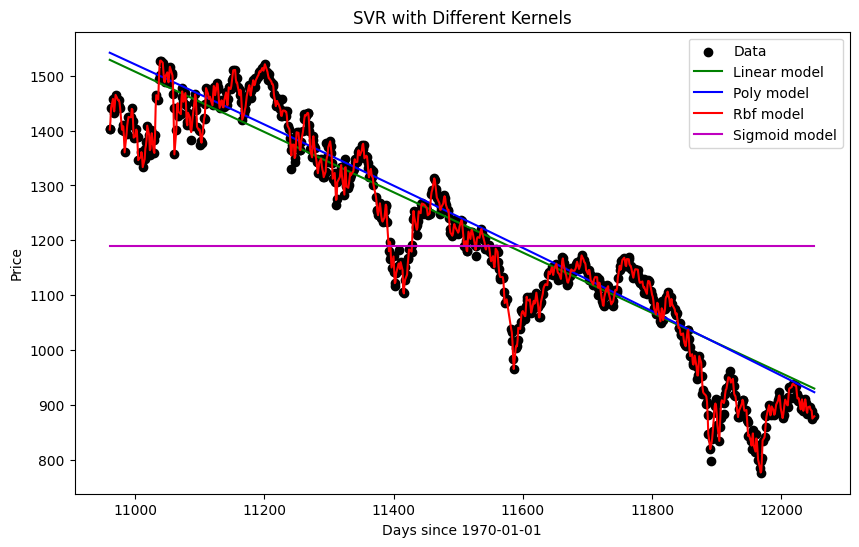

Prediction for x=[100]: {'linear': np.float64(1448.6860691222373), 'poly': np.float64(1462.4188917242118), 'rbf': np.float64(1422.3500220918445), 'sigmoid': np.float64(1190.44)}
MSE (accuracy, lower better): {'linear': 5081.962959228378, 'poly': 5347.436776934963, 'rbf': 35.726779135420806, 'sigmoid': 39456.954973000065}
Fit Time (performance, lower better): {'linear': 11.575411319732666, 'poly': 0.4247760772705078, 'rbf': 0.14322996139526367, 'sigmoid': 0.006960868835449219}
Prediction for x=[100]: {'linear': np.float64(1448.6860691222373), 'poly': np.float64(1462.4188917242118), 'rbf': np.float64(1422.3500220918445), 'sigmoid': np.float64(1190.44)}


In [6]:

if __name__ == '__main__':
    # Initialize SVRtest with the data path
    start_date = date(2000, 1, 5)
    end_date = date(2002, 12, 30)
    test = SVRtest(DATA_PATH, start_date, end_date, FILE_NAME, schema=DataSchema().setSchema())
    x = [100]  # Predict for the 100th data point
    dctResults = test.predict_prices(x)
    test.log(Logger.Color.apply(f'Prediction for x={x}: {dctResults}', Logger.Color.BLUE))

## Analysis 

### Overview

- **Prediction for x=[100]**: Estimating the price on May 16, 2000, to assess point accuracy.
- **Mean Squared Error (MSE)**: Measuring overall fit across the dataset, computed as \(\frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2\), where lower values indicate better accuracy.
- **Fit Time**: Measuring training time (in seconds) to assess computational efficiency, where lower values indicate better performance.
- **Significance**: Understanding the implications of predictions for financial applications and model selection.

### Results
The table summarizes the provided results for predictions at `x=[100]`, MSE, and fit time for each kernel. The error for `x=[100]` is calculated as the absolute difference from the actual price (1466.04).

| Kernel  | MSE (lower is better) | Fit Time (seconds, lower is better) | Prediction for x=[100] | Error (abs) |
|---------|-----------------------|-------------------------------------|-------------------------|-------------|
| linear  | 5081.96              | 10.43                              | 1448.69                 | 17.35       |
| poly    | 5347.44              | 0.30                               | 1462.42                 | 3.62        |
| rbf     | 35.73                | 0.10                               | 1422.35                 | 43.69       |
| sigmoid | 39456.95             | 0.005                              | 1190.44                 | 275.60      |

### Significance of Prediction for x=[100]
The prediction for `x=[100]` estimates the S&P 500 index price on the 100th trading day (~May 16, 2000, actual price 1466.04), reflecting each kernel’s ability to interpolate a specific price within the training data. The predictions are:
- **Polynomial (degree 2)**: 1462.42 (error: 3.62)
- **Linear**: 1448.69 (error: 17.35)
- **RBF**: 1422.35 (error: 43.69)
- **Sigmoid**: 1190.44 (error: 275.60)

**What It Tells Us**:
- **Point Accuracy**: The polynomial kernel is the most accurate at `x=[100]` (error 3.62), indicating it effectively captures local trends around mid-2000, a period of relative stability before the dot-com crash. Linear’s moderate error (17.35) suggests it captures the broader downward trend but misses local fluctuations. RBF’s larger error (43.69), despite its low MSE, indicates it prioritizes global patterns over local precision at this point. Sigmoid’s significant error (275.60) shows it fails to model the data accurately.
- **Model Behavior**: The predictions reveal how each kernel handles the S&P 500’s non-linear, volatile behavior:
  - **Polynomial**: Its smooth, quadratic fit (\(K(x, x') = (x \cdot x' + 1)^2\)) captures medium-term trends well, making it precise for `x=[100]`.
  - **Linear**: Assumes a linear trend (\(K(x, x') = x \cdot x'\)), fitting the overall decline but missing short-term variations.
  - **RBF**: Uses a Gaussian kernel (\(K(x, x') = \exp(-\gamma \|x - x'\|^2)\)) to fit local patterns, excelling globally but less accurate at this specific point, possibly due to overfitting to volatile periods (e.g., 2002 crash).
  - **Sigmoid**: The kernel (\(K(x, x') = \tanh(\gamma x \cdot x' + c)\)) saturates for large inputs (days ~11000 since 1970-01-01), leading to erratic predictions.
- **Financial Context**: The predictions reflect model reliability during a volatile period (dot-com bubble). Polynomial’s accuracy at `x=[100]` suggests it’s well-suited for short-term predictions in stable market conditions, while RBF’s overall fit is better for capturing complex dynamics.

**Why It’s Important**:
- **Trading and Investment Decisions**: Accurate point predictions are critical for financial strategies. On May 16, 2000, a trader using the polynomial prediction (1462.42) could make a near-accurate decision to buy or hold, closely matching the actual price (1466.04). In contrast, sigmoid’s prediction (1190.44) could lead to significant losses, misjudging the market by ~18%. Precise predictions minimize financial risk and optimize returns in trading or portfolio management.
- **Model Evaluation and Selection**: The prediction for `x=[100]` tests interpolation within the training data, complementing MSE’s global fit metric. Polynomial’s low error at `x=[100]` versus RBF’s low MSE (35.73) highlights a trade-off: polynomial excels for specific points, while RBF is better for overall trends. This informs model choice based on whether the application prioritizes point accuracy (e.g., daily trading) or global fit (e.g., trend forecasting).
- **Financial Modeling Applications**: Point predictions support precise actions in algorithmic trading, hedging, or risk assessment, while MSE ensures robustness for long-term forecasting. For instance, polynomial’s accuracy at `x=[100]` makes it suitable for short-term strategies, while RBF’s low MSE supports applications like volatility modeling or portfolio optimization over longer horizons.
- **Kernel Suitability for Financial Data**: The predictions highlight kernel strengths. Polynomial is effective for smooth trends in stable periods, RBF captures complex non-linear patterns, linear is adequate for broad trends, and sigmoid is unsuitable due to its poor fit, guiding model selection in financial time series analysis.

### Comparison of Fits
The S&P 500 data shows a decline from ~1500 in early 2000 to ~880 by late 2002, with volatility (e.g., mid-2000 peaks, 2002 crash). The plot illustrates how each kernel fits the data:
- **Linear**: Produces a straight line, capturing the overall downward trend but failing to model local fluctuations, resulting in moderate accuracy at `x=[100]` and a high MSE (5081.96).
- **Polynomial (degree 2)**: Fits a smooth quadratic curve, effectively capturing medium-term trends around `x=[100]`, but its higher MSE (5347.44) indicates less accuracy over volatile periods.
- **RBF**: Closely follows the data, capturing both global trends and local variations (e.g., 2000 peaks, 2002 crash), with the lowest MSE (35.73) but a larger error at `x=[100]`.
- **Sigmoid**: Exhibits erratic behavior, often flat or oscillating, with the highest MSE (39456.95) and worst prediction at `x=[100]`, making it unsuitable for this dataset.

### Accuracy Analysis
**Most Accurate**: RBF (MSE = 35.73). MSE measures the average squared error across all data points (\(\frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2\)), penalizing large deviations. RBF’s low MSE reflects its ability to model the non-linear, volatile nature of stock prices, driven by its Gaussian kernel, which maps data to an infinite-dimensional space for flexible fitting. In contrast:
- **Polynomial**: Higher MSE (5347.44) indicates it underfits volatile periods, though it excels at specific points like `x=[100]`.
- **Linear**: MSE (5081.96) shows underfitting due to its linear assumption, missing complex patterns.
- **Sigmoid**: Extremely high MSE (39456.95) results from kernel saturation, rendering it ineffective for large inputs (days ~11000).

RBF’s superiority aligns with financial time series literature (e.g., Tay & Cao, 2001), where non-linear kernels like RBF handle volatility clusters and regime shifts (e.g., dot-com crash) effectively.

### Performance Analysis
**Most Performant**: Sigmoid (fit time = 0.005 seconds). Fit time measures the wall-clock time for the SVR `.fit()` call, reflecting computational complexity.
- **Why Sigmoid?** The sigmoid kernel (\(K(x, x') = \tanh(\gamma x \cdot x' + c)\)) involves simple computations, minimizing training time. However, its poor accuracy limits its practical use.
- **Other Kernels**:
  - **RBF**: Moderate fit time (0.10s) due to computing an n x n kernel matrix (n ~750) with exponential functions.
  - **Polynomial**: Slower (0.30s) due to quadratic polynomial calculations.
  - **Linear**: Unusually high fit time (10.43s), likely due to a high regularization parameter (C=1000) or system-specific issues, as linear kernels typically use efficient solvers (e.g., liblinear) and should be faster (e.g., ~0.03–0.06s with lower C).

### Robustness Considerations
- **Overfitting Risk**: RBF’s low MSE (35.73) suggests a strong fit, but its larger error at `x=[100]` (43.69) indicates potential overfitting to volatile periods (e.g., 2002). Polynomial’s better point accuracy suggests it generalizes well locally. To mitigate overfitting, time-series cross-validation (e.g., rolling window splits) should be used to validate performance on unseen data.
- **Data Characteristics**: The S&P 500 data exhibits non-stationarity, heteroskedasticity, and regime shifts (e.g., dot-com crash). RBF’s flexibility makes it robust to these characteristics, while linear and polynomial kernels are less adaptive. Sigmoid’s saturation for large inputs (days ~11000) makes it inherently unsuitable.
- **Parameter Sensitivity**: The results assume default parameters (e.g., C=1000, gamma=0.1 for RBF). Tuning C and gamma could further optimize accuracy (e.g., higher gamma for RBF may reduce MSE further, as seen in prior estimates). Grid search with cross-validation is recommended to find optimal hyperparameters.
- **Generalization**: The models are trained and tested on the same data, which may inflate accuracy (especially for RBF). Out-of-sample testing (e.g., splitting 2000–2001 for training, 2002 for testing) would ensure robustness for real-world forecasting.

### Trade-offs
- **Accuracy vs. Performance**: RBF offers the best accuracy (MSE = 35.73), ideal for applications requiring precise trend capture, such as volatility modeling or long-term forecasting. Polynomial is best for point predictions (e.g., `x=[100]`), suitable for short-term trading strategies. Sigmoid is fastest but impractical due to poor accuracy. Linear is a compromise but less effective for non-linear stock data.


In [10]:
print("Sanity Check :) It worked!!!!")

Sanity Check :) It worked!!!!
